In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.bloch import BlochWaves, StructureFactor

import abtem

abtem.config.set(
    {
        "precision": "float64",
        "device": "gpu",
    }
)

# Blochwave simulations

Blochwave simulations, are implemented in abTEM, as an alternative to the multislice simulations, offering advantages under certain conditions. Blochwave allows for simulations of structures with arbitrary crystal rotations and arbitrary unit cells, which are difficult to handle in multislice due to the requirement of orthogonal and periodic unit cells.
Blochwave is efficient for crystals described by small unit cells, but is scales as  in both memory and time. Hence, becomes prohibitively expensive for large unit cells.

In this tutorial, we go through how to perform blochwave simulations as implemented in *ab*TEM, and compare the simulation results to multislice.

:::{admonition} {material-regular}`engineering;1.5rem;sd-mr-1` Currently Under Construction
:class: no-icon
This section uses a new relatively untested feature.
:::

## Structure factor

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

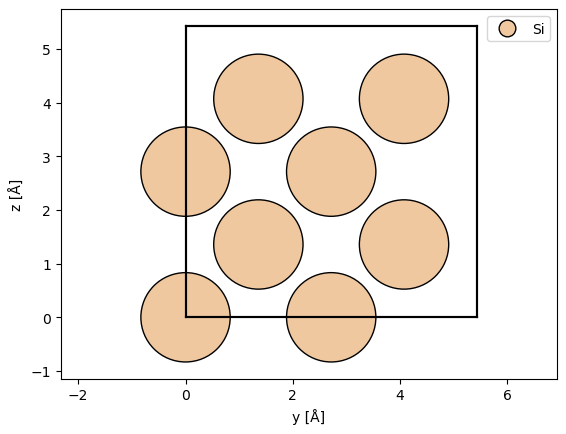

In [2]:
atoms = ase.build.bulk("Si", cubic=True)

abtem.show_atoms(atoms, legend=True, plane="yz")

In [3]:
k_max = 12

structure_factor = StructureFactor(
    atoms,
    k_max=k_max,
    parametrization="lobato",
)

In [4]:
sg_max = 0.1

bloch_waves = BlochWaves(
    structure_factor=structure_factor,
    energy=200e3,
    sg_max=sg_max,
)

In [5]:
len(bloch_waves)

3573

The selected beams can be accessed through the `hkl` property.

In [6]:
bloch_waves.hkl

array([[ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  2,  0],
       ...,
       [-1, -3,  0],
       [-1, -2,  0],
       [-1, -1,  0]])

In [7]:
thicknesses = np.arange(0, 1086 + 0.1, 5.43)

diffraction_thickness_series = bloch_waves.calculate_diffraction_patterns(thicknesses)

diffraction_thickness_series

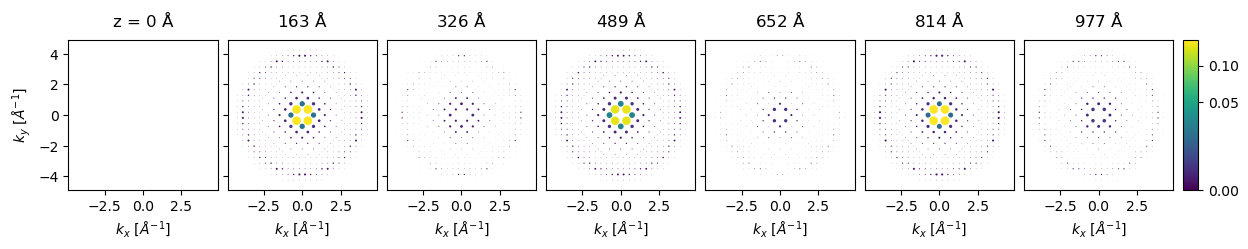

In [8]:
diffraction_thickness_series[::30].crop(k_max=4.5).block_direct().show(
    explode=True,
    scale=0.08,
    power=0.5,
    annotations=False,
    figsize=(14, 5),
    common_color_scale=True,
    cbar=True,
)

In [9]:
data_array = diffraction_thickness_series.to_data_array()

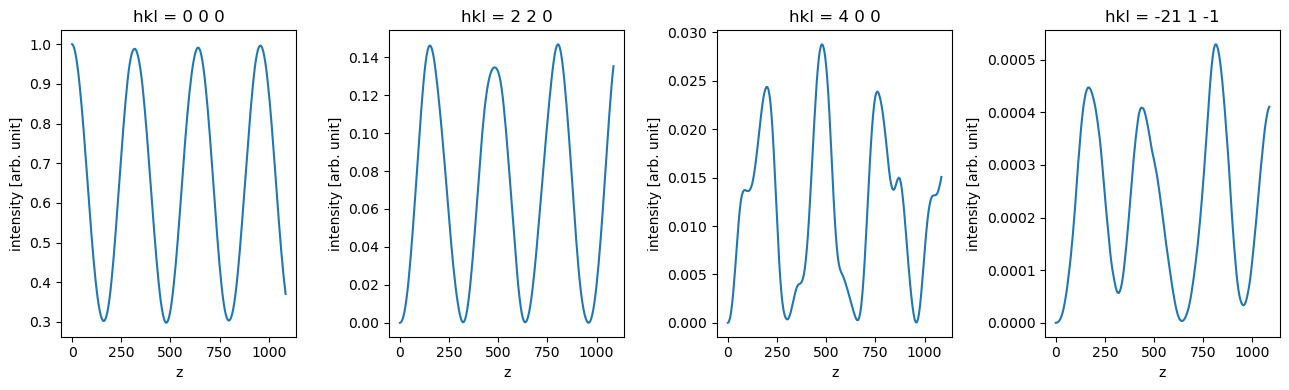

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(13, 4))

for ax, hkl in zip(axes, ["0 0 0", "2 2 0", "4 0 0", "-21 1 -1"]):
    data_array.sel(hkl=hkl).plot(hue="hkl", ax=ax)

plt.tight_layout()

## Rotations

We can get diffraction intensities from other directions using the `rotations` method. Here, we rotate about $z$ at $4$ different angles between $0$ and $45 \ \mathrm{deg}$, for each $z$ rotation we also rotate around $x$ at $5$ different angles between $0$ and $45 \ \mathrm{deg}$, i.e. resulting in $16$ different simulations. 

In [11]:
x = np.linspace(0, np.pi / 4, 4)
z = np.linspace(0, np.pi / 4, 4)

ensemble = bloch_waves.rotate("z", z, "x", x)

ensemble

The previous operation produces a `BlochwaveEmsenble` object, we run the same `calculate_diffraction_patterns` method to create the tasks for running a Bloch wave simulation for each direction.

In [12]:
diffraction_patterns = ensemble.calculate_diffraction_patterns(thicknesses=1000)

diffraction_patterns.array

dask.array<getitem, shape=(4, 4, 32283), dtype=float64, chunksize=(1, 1, 32283), chunktype=numpy.ndarray>

In [13]:
diffraction_patterns.compute()

[########################################] | 100% Completed | 46.23 s


In [14]:
diffraction_patterns.shape

(4, 4, 32283)

In [15]:
diffraction_patterns = diffraction_patterns.remove_low_intensity(1e-6)

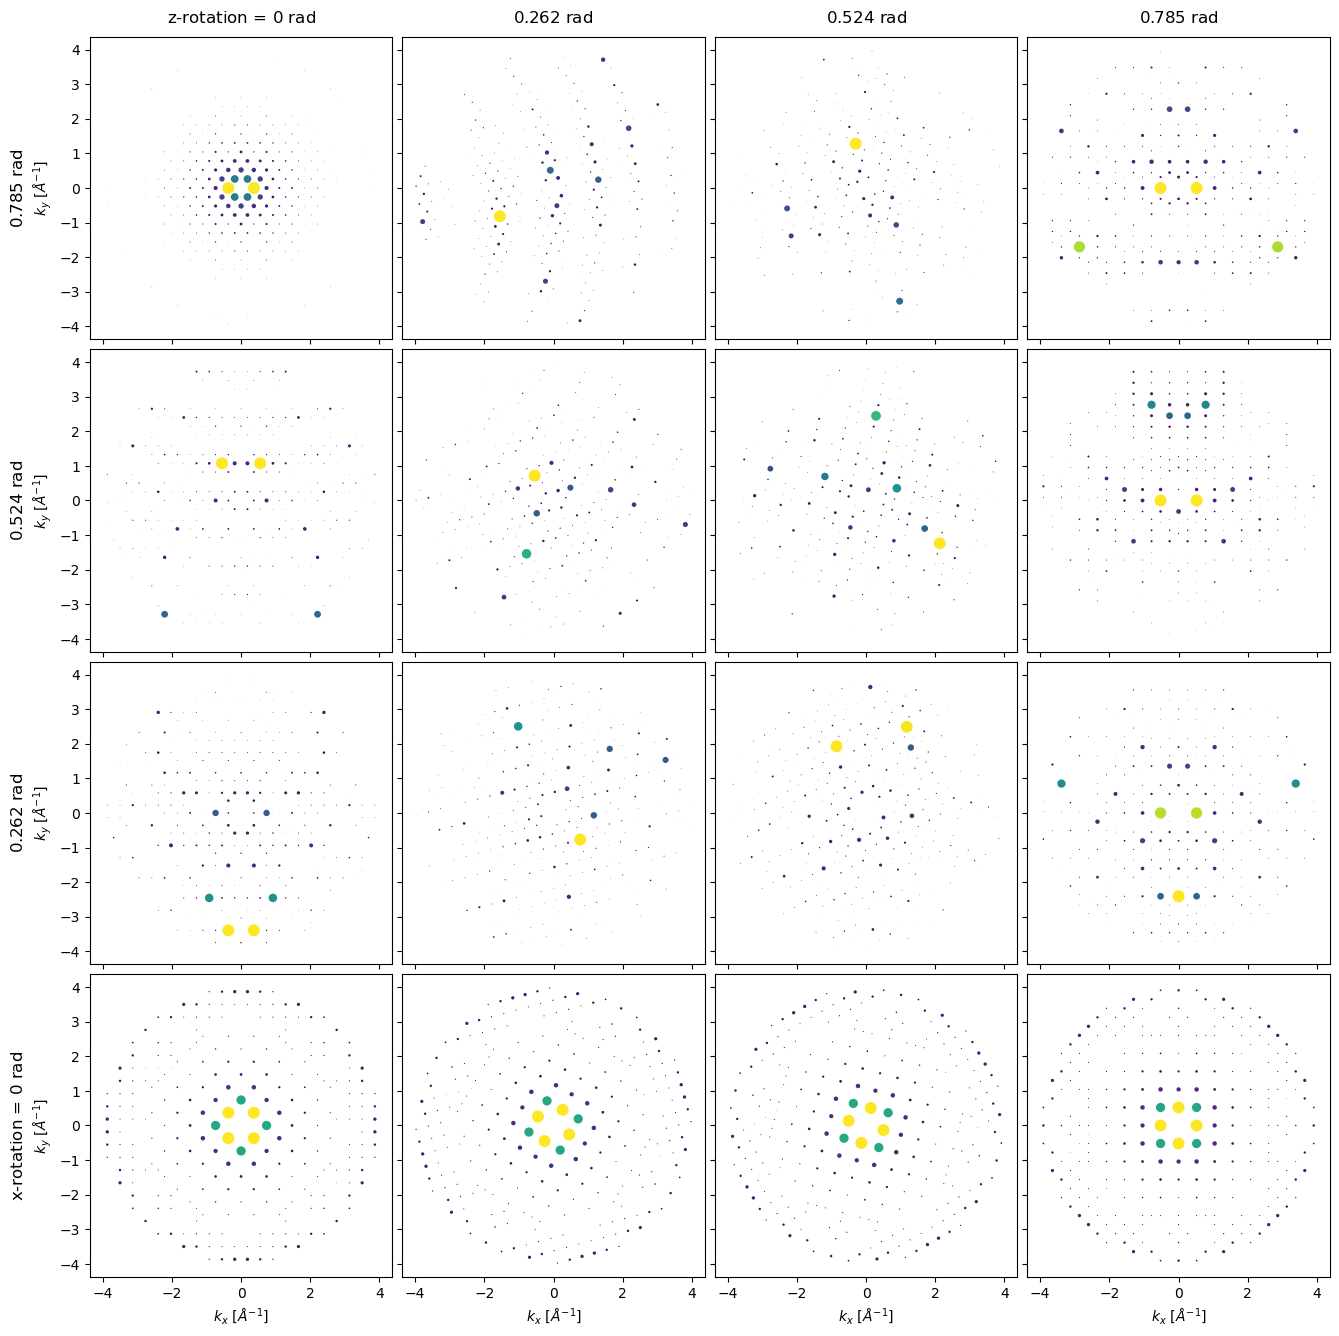

In [16]:
diffraction_patterns.crop(k_max=4).block_direct().show(
    explode=True,
    scale=0.03,
    power=0.5,
    annotation_kwargs={"threshold": 1},
    figsize=(14, 14),
)

Arbitrary rotations may be given as a sequence of [euler angles](), for example, to rotate about a vector pointing along $(-1, 1, 0)$, we can rotate by $\pi/4$ around $z$, apply the desired rotations around $x$, and then rotate back by $-\pi/4$ around $z$.

In [17]:
z = np.tile([np.pi / 4], (4,))
x = np.linspace(0, np.pi / 2, 4)

rotations = np.array([z, x, -z]).T

In [18]:
ensemble = bloch_waves.rotate("zxz", rotations)

diffraction_patterns = ensemble.calculate_diffraction_patterns(1000).compute()

[########################################] | 100% Completed | 9.69 ss


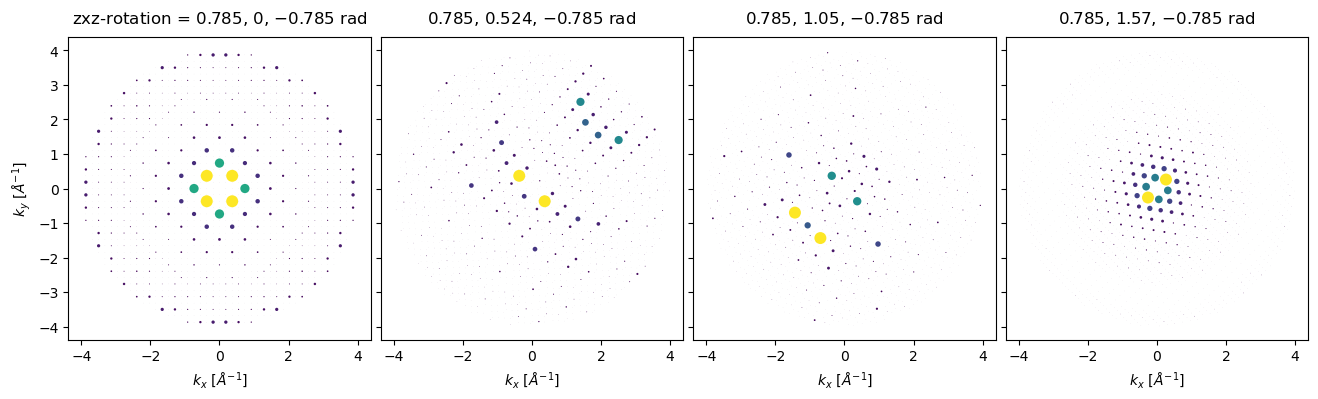

In [19]:
diffraction_patterns.crop(k_max=4).block_direct().show(
    explode=True,
    scale=0.03,
    power=0.5,
    annotation_kwargs={"threshold": 1},
    figsize=(14, 14),
)

## Comparison to multislice

In [20]:
k_max = 12

structure_factor = StructureFactor(
    atoms, k_max=k_max, parametrization="lobato", centering="F", thermal_sigma=0.078
)

In [21]:
potential_sf = structure_factor.get_projected_potential(slice_thickness=0.5)

potential_sf.sampling

(0.04082706766917293, 0.04082706766917293)

In [22]:
parametrization = abtem.parametrizations.LobatoParametrization(
    sigmas={"Si": 0.078 * np.sqrt(3)}
)

potential = (
    abtem.Potential(
        atoms,
        sampling=potential_sf.sampling,
        slice_thickness=0.1,
        projection="finite",
        parametrization=parametrization,
    )
    .build()
    .compute(progress_bar=False)
)

[########################################] | 100% Completed | 205.39 ms


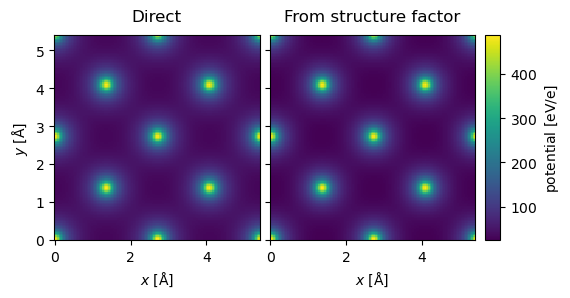

In [23]:
stack = abtem.stack(
    (potential.project(), potential_sf.project()), ("Direct", "From structure factor")
).compute()

stack.show(explode=True, common_color_scale=True, cbar=True);

In [24]:
pw = abtem.PlaneWave(energy=200e3)

nz = int(1086 / potential.thickness)

repeated_potential = abtem.CrystalPotential(
    potential, repetitions=[1, 1, nz], exit_planes=potential.num_slices
)

exit_waves_ms = pw.multislice(potential=repeated_potential).compute()

[########################################] | 100% Completed | 14.37 s


In [25]:
bloch_waves = BlochWaves(
    structure_factor=structure_factor, energy=200e3, sg_max=sg_max, paraxial=True
)

len(bloch_waves)

901

In [26]:
exit_waves_bw = bloch_waves.calculate_exit_wave(
    repeated_potential.exit_thicknesses, gpts=exit_waves_ms.gpts
)

TypeError: BlochWaves.calculate_exit_wave() missing 1 required positional argument: 'extent'

In [ ]:
exit_waves_bw.shape

In [ ]:
exit_waves_ms.shape

In [ ]:
stack = abtem.stack(
    [exit_waves_bw, exit_waves_ms],
    axis_metadata={"label": "algorithm", "values": ["MS", "BW"]},
    axis=1,
)

In [ ]:
stack.shape

In [ ]:
stack[1::30].show(explode=True, figsize=(12, 4))

In [ ]:
stacked_diffraction = (
    stack.to_cpu().diffraction_patterns().index_diffraction_spots(cell=atoms)
)

The difference below is mostly do to unconverged bloch wave.

In [ ]:
data_array = stacked_diffraction.to_data_array()

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, hkl in zip(axes, ["0 0 0", "2 2 0", "4 0 0", "-21 1 -1"]):
    data_array.sel(hkl=hkl).plot(hue="algorithm", ax=ax)

plt.tight_layout()

## Rotating multislice simulations with periodic boundaries

In [ ]:
rotated_atoms = ase.build.bulk("Si", cubic=True)

angle = np.arctan(1 / 2)

rotated_atoms.rotate("x", angle * 180 / np.pi, rotate_cell=True)

rotated_atoms = abtem.orthogonalize_cell(rotated_atoms)

abtem.show_atoms(rotated_atoms, legend=True, plane="xy")

In [ ]:
parametrization = abtem.parametrizations.LobatoParametrization(
    sigmas={"Si": 0.078 * np.sqrt(3)}
)

potential = abtem.Potential(
    atoms,
    sampling=0.05,
    slice_thickness=0.1,
    projection="finite",
    parametrization=parametrization,
)